# This notebook is meant to create functions for plotting 

Goal is then to add them to the classes or as checks that everything is well

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy 
from tempest import grid
from tempest import joint_distrib
from tempest import handler
from tempest import storm_tracker

settings_path = 'settings/tropics.yaml'

In [4]:
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, simpler_grid = False, fast = True, overwrite= False, verbose_steps = False, verbose = False)

# if __name__ == '__main__':
#     st = storm_tracker.StormTracker(gr, overwrite = False) #overwrite = True is super long
#     st_feng = storm_tracker.StormTracker(gr, label_var_id = "MCS_label_Tb_Feng", overwrite = False)
    # pass


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


In [5]:
mcs_feng = gr.get_var_id_ds("MCS_label_Tb_Feng").MCS_label_Tb_Feng.values
mcs = gr.get_var_id_ds("MCS_label").MCS_label.values
prec_lag =gr.get_var_id_ds('Prec_t_minus_1').mean_Prec_t_minus_1
prec = gr.get_var_id_ds("Prec").mean_Prec
print(prec.shape)
print(prec_lag.shape)
print(mcs.shape)
print(mcs_feng.shape)

AttributeError: 'Dataset' object has no attribute 'MCS_label_Tb_Feng'

In [6]:
def arrays_equal_except_nan(arr1, arr2):
    # Check if the shapes of the arrays are the same
    if arr1.shape != arr2.shape:
        return False
    
    # Check element-wise equality, ignoring NaN values
    nan_mask = np.isnan(arr1) | np.isnan(arr2)
    equal_except_nan = np.array_equal(np.where(nan_mask, True, arr1), np.where(nan_mask, True, arr2))
    
    return equal_except_nan

# JointDistrib with max Prec vs Mean Prec

In [69]:
# jd = joint_distrib.JointDistribution(gr, st, var_id = 'Prec', var_id_1 = "mean_Prec", var_id_2 = "max_Prec", nd=5, overwrite = True)
# jd_feng = joint_distrib.JointDistribution(gr, st_feng, var_id = 'Prec', var_id_1 = "mean_Prec", var_id_2 = "max_Prec", nd = 5, overwrite = True)

# jd_lag = joint_distrib.JointDistribution(gr, st, var_id = 'Prec_t_minus_1', var_id_1 = "mean_Prec_t_minus_1", var_id_2 = "max_Prec_t_minus_1", nd=5, overwrite = True)
# jd_feng_lag = joint_distrib.JointDistribution(gr, st_feng, var_id = 'Prec_t_minus_1', var_id_1 = "mean_Prec_t_minus_1", var_id_2 = "max_Prec_t_minus_1", nd = 5, overwrite = True)

First instance of this Joint Distribution, so setting overwrite to true
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.65 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.41 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.55 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.50 seconds


## Density regions (without density first yes idk)

In [35]:
%matplotlib inline
jd.plot(branch=False)
jd_feng.plot(branch = False)

jd_lag.plot(branch=False)
jd_feng_lag.plot(branch = False)

NameError: name 'jd' is not defined

## Show Regions on map

In [8]:
# import cartopy.crs as ccrs
# %matplotlib inline
# # Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)
# jd.make_mask()

# mask_all = jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90
# mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
# mask_labels = 'conv','mostlyconv','mostlyacc','acc'

# for mask,mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
#     print(mask_name)
#     mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
#     ax = jd.make_map(mask_yxt)
#     lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
#     lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
#     ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
#                 [lat_min, lat_min, lat_max, lat_max, lat_min],
#                 color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
#     lon_min, lon_max = 130, 185 #gr.lon_slice.start , gr.lon_slice.stop
#     lat_min, lat_max = 0, 20#gr.lat_slice.start, gr.lat_slice.stop
#     ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
#                 [lat_min, lat_min, lat_max, lat_max, lat_min],
#                 color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
#     ax.legend()
    
#     ax.set_title(mask_name)

#     # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.pdf'%(mask_label)),bbox_inches='tight')
#     # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## Look at MCS bin fraction

In [9]:
def get_mcs_bin_fraction(self, bin_noise_treshold = 4):
    n_i, n_j = self.bincount.shape
    bin_fraction_mcs = np.full((n_i,n_j),np.nan)
    bin_noise = np.full((n_i,n_j),np.nan)
    bin_counts = np.full((n_i,n_j),np.nan)

    for i_bin in range(n_i):
        for j_bin in range(n_j):
    
            # where bin falls in x-y-t
            mask_bin_yxt = self.get_mask_yxt(i_bin,j_bin)
        
            # where bin falls in x-y-t and MCS occurs
            mask_bin_with_mcs_yxt = np.logical_and(mask_bin_yxt,self.mask_labels_regridded_yxt)
            
            # number of points in joint mask
            count_bin_mcs = np.sum(mask_bin_with_mcs_yxt)
            
            # number of point in bin mask
            count_bin = np.sum(mask_bin_yxt)
            
            bin_counts[i_bin,j_bin] = count_bin
            # store this fraction
            if count_bin >= bin_noise_treshold:
                bin_fraction_mcs[i_bin,j_bin] = count_bin_mcs/count_bin
            elif count_bin > 0:
                bin_noise[i_bin,j_bin] = 1
            # include noisy points in bin_fraction_mcs
            # if count_bin > 0:
            #     bin_fraction_mcs[i_bin,j_bin] = count_bin_mcs/count_bin
            #     if count_bin <= 4:
            #         bin_noise[i_bin,j_bin] = 1
    
    # return this fraction
    return bin_fraction_mcs, bin_noise, bin_counts

## no lag

<AxesSubplot:xlabel='1$^\\circ\\times 1$day mean_Prec', ylabel='4km-30mn max_Prec'>

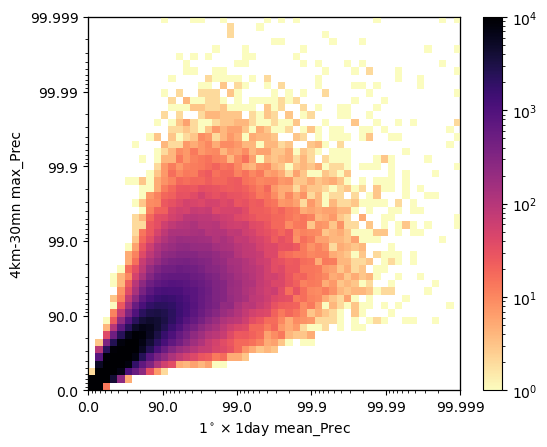

In [10]:
jd.plot_data(jd.bincount, scale = 'log', cmap=plt.cm.magma_r ,  vbds = (1, 1e4))

<AxesSubplot:xlabel='1$^\\circ\\times 1$day mean_Prec', ylabel='4km-30mn max_Prec'>

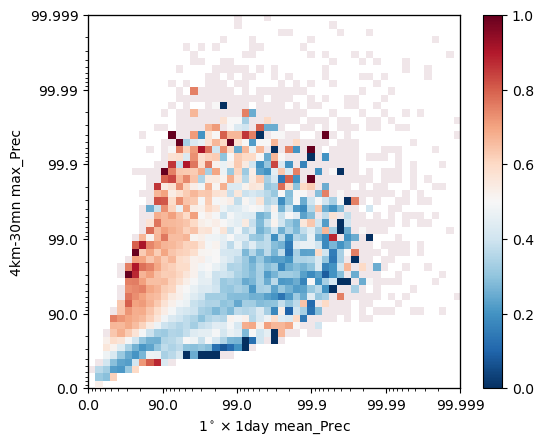

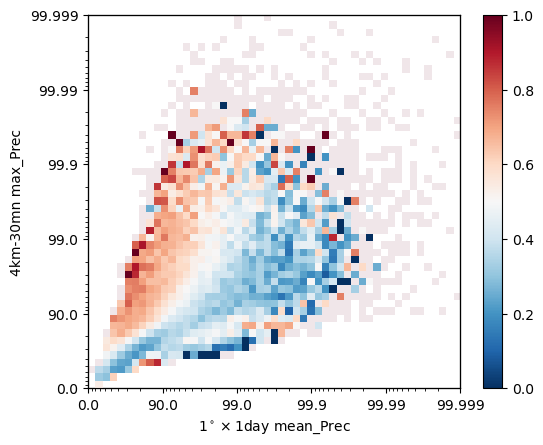

In [11]:
data, noise, count = get_mcs_bin_fraction(jd, 4)
jd.plot_data(data, noise, branch=False, vbds = (0, 1))

data_feng, noise, count = get_mcs_bin_fraction(jd_feng, 4)
jd_feng.plot_data(data_feng, noise, branch=False, vbds = (0, 1))

In [12]:
i_bin = 1
j_bin = 26
print(data[i_bin, j_bin])
print(jd.labels_in_joint_bin(i_bin, j_bin))
print(np.where(jd.get_mask_yxt(i_bin, j_bin)))

nan
[]
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [7]:
gr.slices_i_lat[51]

slice(2848, 2873, None)

In [37]:
gr.slices_j_lon[51][139] 

slice(3247, 3271, None)

In [38]:
np.linspace(-29.5, 29.5, 60)

array([-29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5,
       -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5,
       -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,
        -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,
         6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,
        15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,
        24.5,  25.5,  26.5,  27.5,  28.5,  29.5])

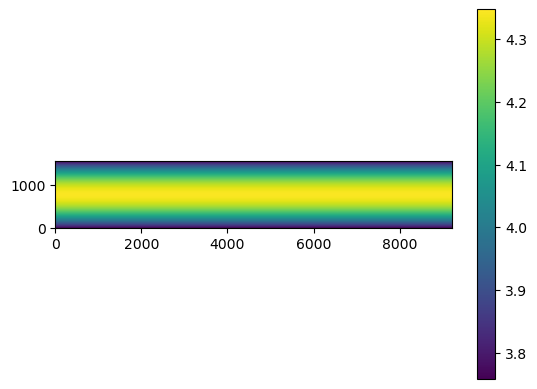

In [71]:
plt.imshow(gr.lon_length_on_center, origin = 'lower')
plt.colorbar()

In [8]:
prec_native = hdlr.load_var(gr, "Prec", 1604)

In [19]:
gr.template_native_df.lat[1520:1540]

<xarray.DataArray 'lat' (lat: 20)>
array([-30.265408, -30.22678 , -30.18815 , -30.149523, -30.110893, -30.072266,
       -30.033638, -29.995008, -29.95638 , -29.917751, -29.879124, -29.840494,
       -29.801867, -29.763237, -29.72461 , -29.685982, -29.647352, -29.608725,
       -29.570095, -29.531467], dtype=float32)
Coordinates:
  * lat      (lat) float32 -30.27 -30.23 -30.19 -30.15 ... -29.61 -29.57 -29.53
Attributes:
    units:    degrees_north

In [40]:
lat = prec_native.lat
lon = prec_native.lon

In [41]:
i_lat_native = []
lat_global = list(range(-30, 31, 1))

for lat_inf, lat_sup in zip(lat_global[:-1], lat_global[1:]):
    i_lat_native_for_global = np.where((lat >=lat_inf) & (lat <= lat_sup))[0]
    i_lat_native.append(i_lat_native_for_global)

i_lon_native = []
lon_global = list(range(0, 361, 1))
for lon_inf, lon_sup in zip(lon_global[:-1], lon_global[1:]):
    i_lon_native_for_global = np.where((lon >= lon_inf) & (lon <= lon_sup))[0]
    i_lon_native.append(i_lon_native_for_global)

In [42]:
slice_i_lat = [slice(lat_native[0], lat_native[-1]) for lat_native in i_lat_native]
slice_j_lon = [slice(lon_native[0], lon_native[-1]) for lon_native in i_lon_native]

In [56]:
global_lat = []
for idx_native_lat in i_lat_native:
    mean_glob_lat = np.mean(lat[idx_native_lat]).values
    global_lat.append(mean_glob_lat)

global_lon = []
for idx_native_lon in i_lon_native:
    mean_glob_lon = np.mean(lon[idx_native_lon]).values
    global_lon.append(np.round((mean_glob_lon), 1))   

In [60]:
import numpy as np

start = 0.5
end = 359.5
num_points = int((end - start) + 1)

np.linspace(0.5, 359.5, 360)



array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
        45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
        54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
        63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
        72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
        81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
        90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
        99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
       108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
       117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
       126.5, 127.5,

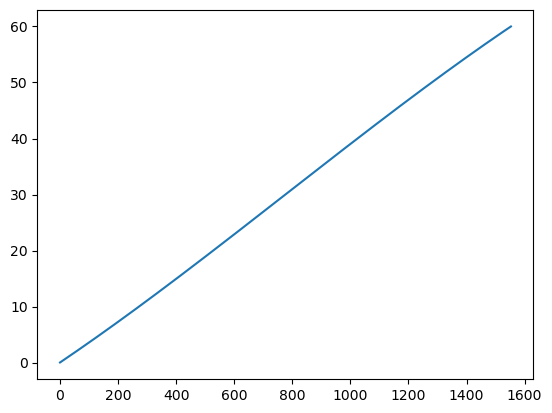

In [50]:
gr.cumsum_lat_area.shape
plt.plot(gr.cumsum_lat_area/gr.global_lat_area)

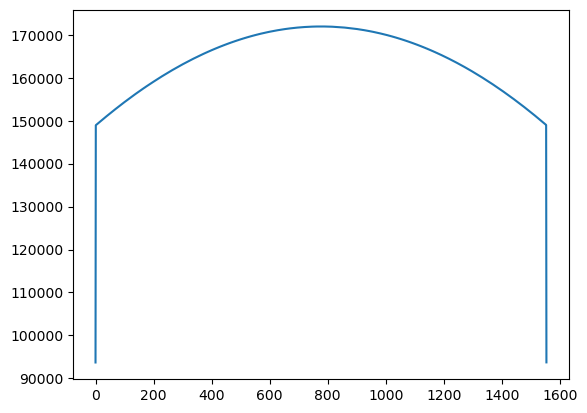

In [19]:
plt.plot(gr.lat_area)

In [20]:
lat_sum = np.sum(gr.cumsum_area_by_lon_and_global_lat, axis =1)

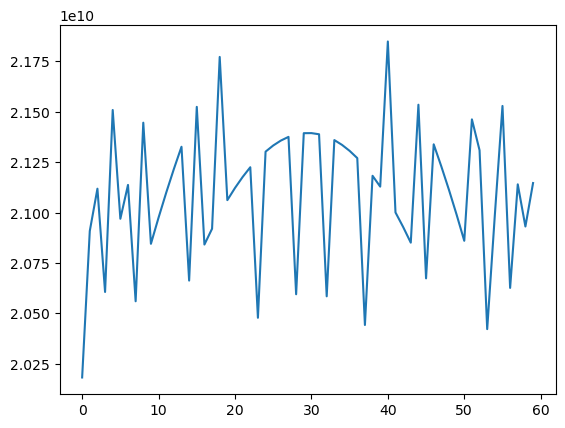

In [21]:
plt.plot(lat_sum)

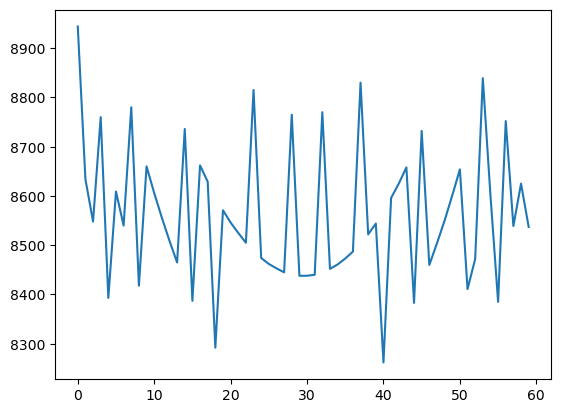

In [22]:
plt.plot(gr.j_max[:, -1])

In [23]:
gr

In [57]:
gr.slices_j_lon[30]

array([slice(0, 23, None), slice(23, 46, None), slice(46, 70, None),
       slice(70, 93, None), slice(93, 117, None), slice(117, 140, None),
       slice(140, 164, None), slice(164, 187, None),
       slice(187, 210, None), slice(210, 234, None),
       slice(234, 257, None), slice(257, 281, None),
       slice(281, 304, None), slice(304, 328, None),
       slice(328, 351, None), slice(351, 375, None),
       slice(375, 398, None), slice(398, 421, None),
       slice(421, 445, None), slice(445, 468, None),
       slice(468, 492, None), slice(492, 515, None),
       slice(515, 539, None), slice(539, 562, None),
       slice(562, 586, None), slice(586, 609, None),
       slice(609, 632, None), slice(632, 656, None),
       slice(656, 679, None), slice(679, 703, None),
       slice(703, 726, None), slice(726, 750, None),
       slice(750, 773, None), slice(773, 796, None),
       slice(796, 820, None), slice(820, 843, None),
       slice(843, 867, None), slice(867, 890, None),
       sli

In [47]:
i_lat, i_lon = 59, 359
prec_native.isel(lat = gr.slices_i_lat[i_lat], lon = gr.slices_j_lon[i_lat][i_lon])

<xarray.DataArray 'Precac' (lat: 29, lon: 24)>
array([[ 6.34193420e-05,  9.25064087e-05,  7.41481781e-05,
         1.39236450e-04,  1.09195709e-04,  1.69754028e-04,
         2.98500061e-04,  5.18798828e-04,  4.17709351e-04,
         3.47137451e-04,  5.45501709e-04,  6.94274902e-04,
         5.26428223e-04,  1.34305954e-01,  3.35174561e-01,
         1.34357452e-01,  6.40869141e-04,  7.74383545e-04,
         6.16073608e-04,  6.59942627e-04,  4.52041626e-04,
         3.87191772e-04,  1.64985657e-04,  6.89029694e-05],
       [ 8.24928284e-05,  5.53131104e-05,  9.72747803e-05,
         1.21593475e-04,  1.62124634e-04,  2.26974487e-04,
         2.72750854e-04,  2.61306763e-04,  3.20434570e-04,
         5.62667847e-04,  7.78198242e-04,  6.56127930e-04,
         6.75201416e-04,  5.70297241e-04,  8.04901123e-04,
         6.98089600e-04,  6.06536865e-04,  7.28607178e-04,
         5.66482544e-04,  3.31878662e-04,  1.82151794e-04,
         1.12056732e-04,  1.23023987e-04,  1.17301941e-04],
       [ 3.92198563e-05,  7.84397125e-05,  2.00271606e-04,
         2.85148621e-04,  5.28335571e-04,  4.25338745e-04,
         4.46319580e-04,  6.12258911e-04,  5.77926636e-04,
         6.98089600e-04,  9.72747803e-04,  6.56127930e-04,
...
         1.23023987e-04,  1.64985657e-04,  1.28269196e-04,
         1.93595886e-04,  7.15255737e-05,  8.10623169e-05,
         8.82148743e-05,  1.64031982e-04,  1.68800354e-04,
         1.56879425e-04,  1.57833099e-04,  3.15666199e-04],
       [ 1.20162964e-04,  8.82148743e-05,  7.72476196e-05,
         1.10626221e-04,  1.74522400e-04,  1.20162964e-04,
         9.87052917e-05,  5.67436218e-05,  1.12056732e-04,
         5.53131104e-05,  8.67843628e-05,  9.10758972e-05,
         8.82148743e-05,  1.02519989e-04,  1.48296356e-04,
         2.98500061e-04,  7.72476196e-05,  1.00135803e-04,
         1.53064728e-04,  2.25067139e-04,  2.37464905e-04,
         1.85966492e-04,  3.00407410e-04,  6.40869141e-04],
       [ 6.34193420e-05,  8.82148743e-05,  2.05039978e-04,
         1.85012817e-04,  1.96456909e-04,  1.66893005e-04,
         1.25408173e-04,  7.84397125e-05,  1.10626221e-04,
         4.05311584e-05,  5.79357147e-05,  6.48498535e-05,
         8.48770142e-05,  9.58442688e-05,  1.00135803e-04,
         2.63214111e-04,  1.51634216e-04,  1.82151794e-04,
         3.31878662e-04,  2.90870667e-04,  3.10897827e-04,
         6.72082901e-02,  5.56945801e-04,  9.57489014e-04]], dtype=float32)
Coordinates:
  * lat      (lat) float32 28.87 28.91 28.95 28.99 ... 29.84 29.88 29.92 29.96
  * lon      (lon) float32 332.6 332.6 332.6 332.7 ... 333.3 333.4 333.4 333.5

In [50]:
last_lon_per_i_lat = []
for i_lat in range(60):
    last_lon_per_i_lat.append(prec_native.isel(lat = gr.slices_i_lat[i_lat], lon = gr.slices_j_lon[i_lat][359]).lon[-1].values)

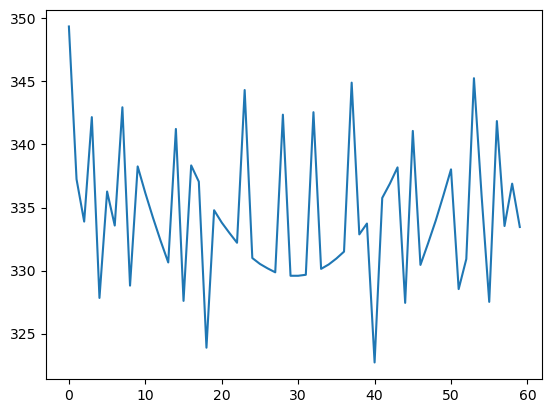

In [51]:
plt.plot(last_lon_per_i_lat)

# lag

<AxesSubplot:xlabel='1$^\\circ\\times 1$day mean_Prec_t_minus_1', ylabel='4km-30mn max_Prec_t_minus_1'>

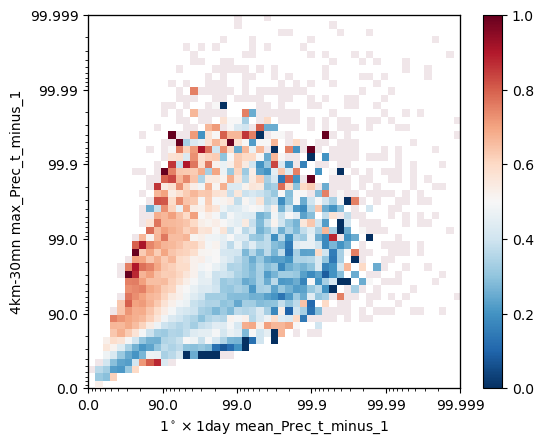

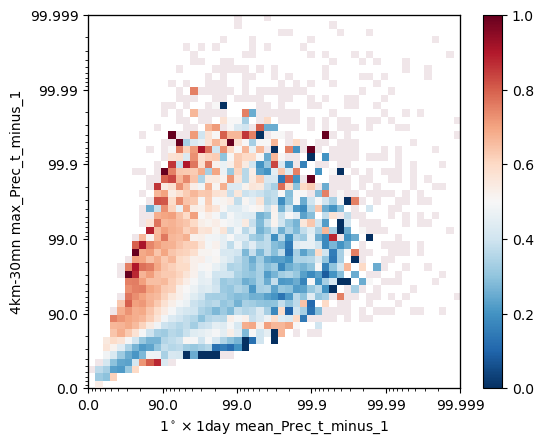

In [18]:
data_lag, noise, count = get_mcs_bin_fraction(jd_lag, 3)
jd_lag.plot_data(data, noise, branch=False, vbds = (0, 1))

data_feng_lag, noise, count = get_mcs_bin_fraction(jd_feng_lag, 3)
jd_feng_lag.plot_data(data_feng, noise, branch=False, vbds = (0, 1))

In [14]:
arrays_equal_except_nan(data_lag, data)

False

## find wrong indexes of precip..

In [13]:
daily_mean_prec = np.load("/home/mcarenso/code/tempest/output/mean_post_modif_prec_tropics.npy")

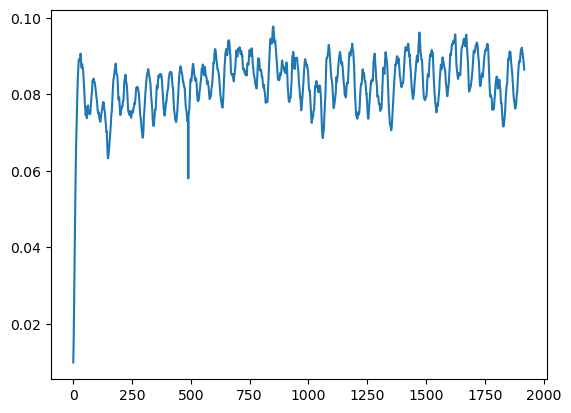

In [14]:
plt.plot(daily_mean_prec)

In [15]:
np.where(daily_mean_prec < 0.06)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10, 489]),)

In [42]:
idx = 491
precac_next = hdlr.load_var(gr, "Precac", idx+1).isel(lat = slice(600, 700), lon = slice(5000,5100))
precac = hdlr.load_var(gr, "Precac", idx).isel(lat = slice(600, 700), lon = slice(5000,5100))
precac_prev = hdlr.load_var(gr, "Precac", idx-1).isel(lat = slice(600, 700), lon = slice(5000,5100))
precac_twice_prev = hdlr.load_var(gr, "Precac", idx-2).isel(lat = slice(600, 700), lon = slice(5000,5100))
plt.imshow(precac_twice_prev, origin = 'lower', cmap = "Blues")
plt.colorbar()

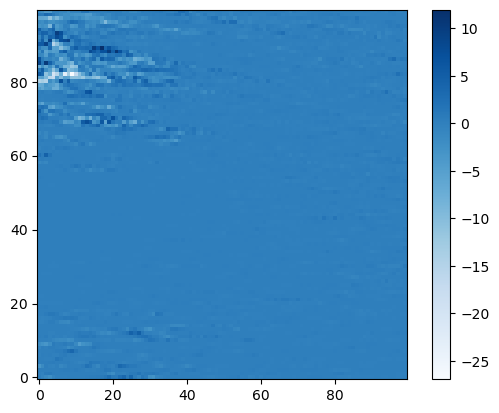

In [44]:
plt.imshow(precac - precac_prev, origin = 'lower', cmap = "Blues")
plt.colorbar()

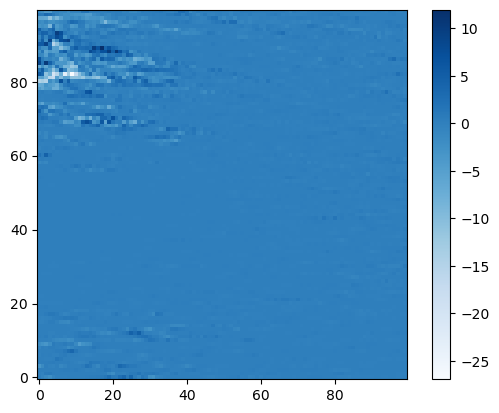

In [41]:
plt.imshow(precac - precac_prev, origin = 'lower', cmap = "Blues")
plt.colorbar()

## QV_sat 2d
quick fix. I add np.nan so that the size matches precip ds

In [ ]:
qv_sat_2d = gr.get_var_id_ds("QV_sat_2d").sortby('days')
mean_qv_sat = qv_sat_2d.mean_QV_sat_2d.values.flatten()
to_fill = len(jd.sample1) - len(mean_qv_sat)
mean_qv_sat_processed = np.pad(mean_qv_sat, (to_fill, 0), mode = 'constant', constant_values=np.nan)

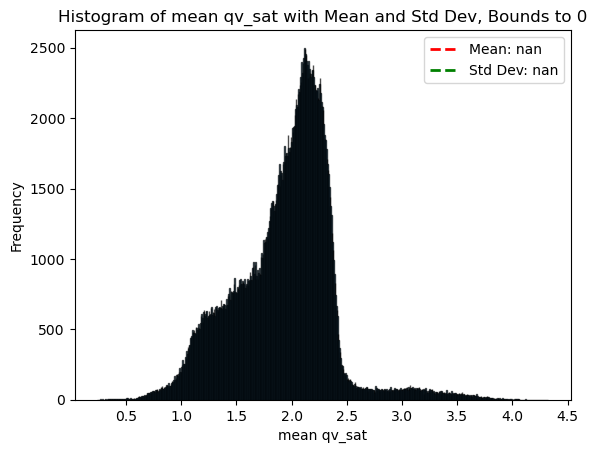

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = mean_qv_sat_processed 
X_mean = np.mean(X)
X_std = np.std(X)

# Create histogram with manually adjusted bins
bins = int(np.sqrt(len(X)))

plt.hist(X, bins=bins, edgecolor='black', alpha=0.7)

# Add mean and standard deviation to the plot
plt.axvline(X_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {X_mean:.2f}')
plt.axvline(X_mean + X_std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {X_std:.2f}')
plt.axvline(X_mean - X_std, color='green', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('mean qv_sat')
plt.ylabel('Frequency')
plt.title('Histogram of mean qv_sat with Mean and Std Dev, Bounds to 0')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
qv_sat_2d = gr.get_var_id_ds("QV_sat_2d").sortby('days')
max_qv_sat = qv_sat_2d.max_QV_sat_2d.values.flatten()
to_fill = len(jd.sample1) - len(max_qv_sat)
max_qv_sat_processed = np.pad(max_qv_sat, (to_fill, 0), mode = 'constant', constant_values=np.nan)

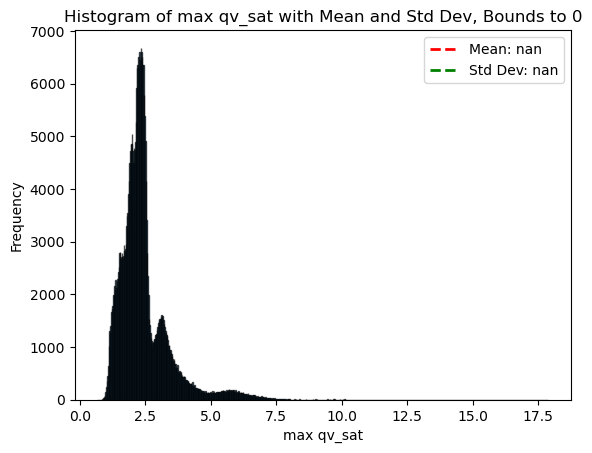

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = max_qv_sat_processed 
X_mean = np.mean(X)
X_std = np.std(X)

# Create histogram with manually adjusted bins
bins = int(np.sqrt(len(X)))

plt.hist(X, bins=bins, edgecolor='black', alpha=0.7)

# Add mean and standard deviation to the plot
plt.axvline(X_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {X_mean:.2f}')
plt.axvline(X_mean + X_std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {X_std:.2f}')
plt.axvline(X_mean - X_std, color='green', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('max qv_sat')
plt.ylabel('Frequency')
plt.title('Histogram of max qv_sat with Mean and Std Dev, Bounds to 0')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
100*hdlr.load_var(gr, "PSFC", 1250).values

array([[104516.664, 104513.82 , 104516.664, ..., 104513.82 , 104514.77 ,
        104515.71 ],
       [104511.914, 104516.664, 104513.82 , ..., 104512.87 , 104513.82 ,
        104512.87 ],
       [104514.77 , 104510.96 , 104508.12 , ..., 104510.96 , 104513.82 ,
        104514.77 ],
       ...,
       [ 98321.664,  98343.516,  98346.375, ...,  98359.67 ,  98362.52 ,
         98355.875],
       [ 98345.42 ,  98338.766,  98354.92 , ...,  98368.23 ,  98372.02 ,
         98362.52 ],
       [ 98350.17 ,  98335.92 ,  98372.98 , ...,  97650.96 ,  98380.56 ,
         98377.72 ]], dtype=float32)

In [ ]:
mean_qv_sat_on_density = jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, mean_qv_sat_processed) 
max_qv_sat_on_density = jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, max_qv_sat_processed) 

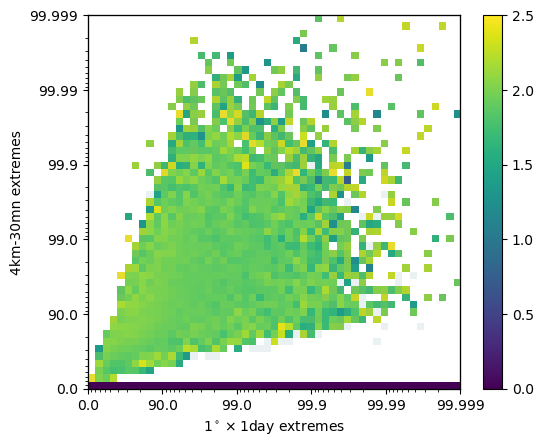

In [ ]:
jd.plot_data(mean_qv_sat_on_density, noise, cmap = plt.cm.viridis, branch=False, vbds = (0, 2.5))
plt.title("Mean QV_sat")

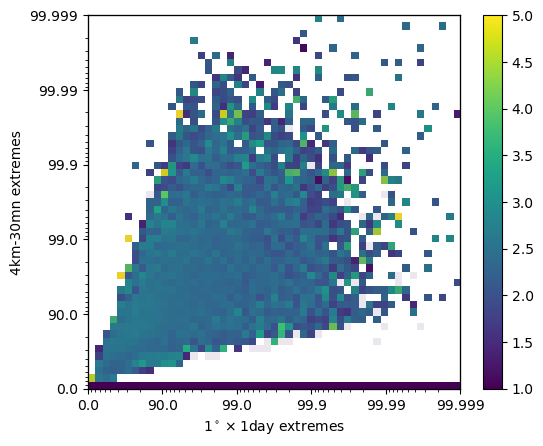

In [ ]:
jd.plot_data(max_qv_sat_on_density, noise, cmap = plt.cm.viridis, branch=False, vbds = (1, 5))
plt.title("Max QV_sat")

# W500

In [ ]:
w500 = gr.get_var_id_ds("W500").sortby('days')
# mean
mean_w500 = w500.mean_W500.values.flatten()
to_remove = - (len(jd.sample1) - len(mean_w500)) # becasue negative
mean_w500_processed = mean_w500[to_remove:]
mean_w500_on_density = jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, mean_w500_processed) 
# max
max_w500 = w500.max_W500.values.flatten()
to_remove = - (len(jd.sample1) - len(max_w500)) # becasue negative
max_w500_processed = max_w500[to_remove:]
max_w500_on_density = jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, max_w500_processed) 

/home/mcarenso/code/tempest/tempest/joint_distrib.py:367: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data.flatten()[data_idx])


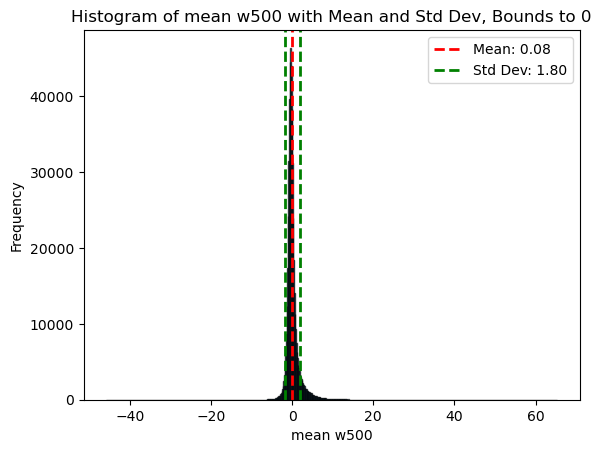

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = 100*mean_w500_processed 
X_mean = np.mean(X)
X_std = np.std(X)

# Create histogram with manually adjusted bins
bins = int(np.sqrt(len(X)))

plt.hist(X, bins=bins, edgecolor='black', alpha=0.7)

# Add mean and standard deviation to the plot
plt.axvline(X_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {X_mean:.2f}')
plt.axvline(X_mean + X_std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {X_std:.2f}')
plt.axvline(X_mean - X_std, color='green', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('mean w500')
plt.ylabel('Frequency')
plt.title('Histogram of mean w500 with Mean and Std Dev, Bounds to 0')

# Show legend
plt.legend()

# Display the plot
plt.show()

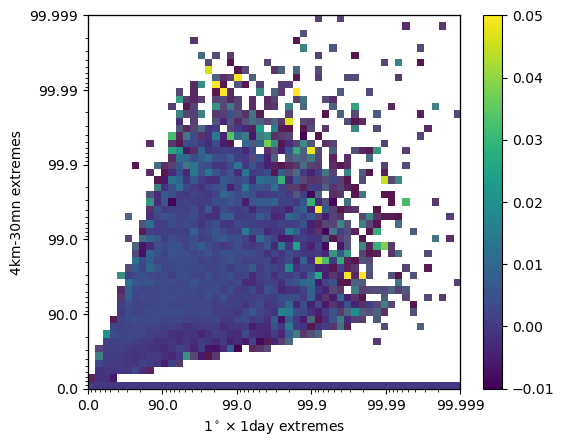

In [ ]:
jd.plot_data(mean_w500_on_density, noise, cmap = plt.cm.viridis, branch=False, vbds = (-0.01, 0.05))

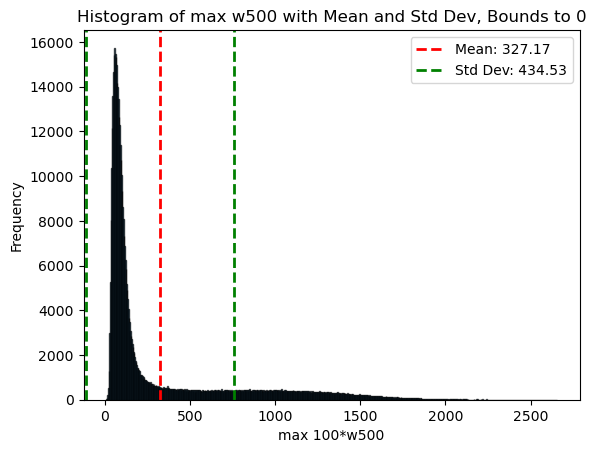

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = 100*max_w500_processed 
X_mean = np.mean(X)
X_std = np.std(X)

# Create histogram with manually adjusted bins
bins = int(np.sqrt(len(X)))

plt.hist(X, bins=bins, edgecolor='black', alpha=0.7)

# Add mean and standard deviation to the plot
plt.axvline(X_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {X_mean:.2f}')
plt.axvline(X_mean + X_std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {X_std:.2f}')
plt.axvline(X_mean - X_std, color='green', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('max 100*w500')
plt.ylabel('Frequency')
plt.title('Histogram of max w500 with Mean and Std Dev, Bounds to 0')

# Show legend
plt.legend()

# Display the plot
plt.show()

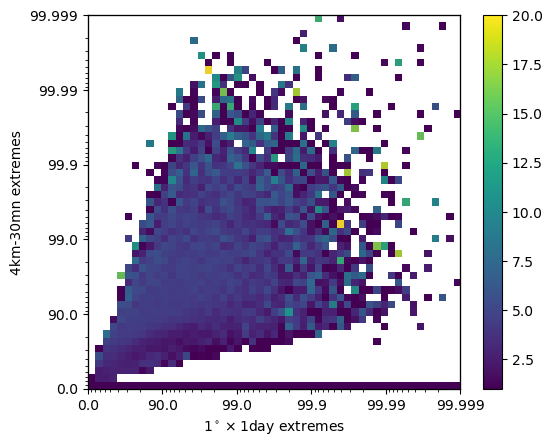

In [ ]:
jd.plot_data(max_w500_on_density, noise, cmap = plt.cm.viridis, branch=False, vbds = (1, 20))

In [ ]:
# A_max = jd.storm_attributes_on_jdist(['surfmaxkm2_172Wm2'], ['max'])
# A_max = A_max[0][0,0]

In [ ]:
# jd.plot_data(A_max, noise, cmap = plt.cm.viridis, branch=False)

In [ ]:
# A_mean = jd.storm_attributes_on_jdist(['surfmaxkm2_172Wm2'], ['mean'])
# A_mean = A_mean[0][0,0]

In [ ]:
# jd.plot_data(A_mean, noise, cmap = plt.cm.viridis, branch=False)

# Old FIX Storms Growth rate pickle safe ! # MCS Growth rate computation

In [ ]:
# from tempest.storm_analysis import set_storm_growth_rate
# compute = True
# if compute:
#     storms_growth_rates = []
#     outputs = [] # r_squared, growth_r_squared, decay_r_squared, t_breaks, s_max
#     for storm in jd.storms:
#         output = set_storm_growth_rate(storm) # total, growth, decay
#         storms_growth_rates.append(storm.growth_rate)
#         outputs.append(output)
#     ## save the babies pls
#     storms_growth_rates = np.array(storms_growth_rates)
#     file = os.path.join(jd.jd_path, 'storms_growth_rates.npy')
#     np.save(file, storms_growth_rates)
    
#     outputs= np.array(outputs)
#     file = os.path.join(jd.jd_path, 'outputs_growth_rate.npy')

# else : 
#     file = os.path.join(jd.jd_path, 'storms_growth_rates.npy')
#     storms_growth_rates = np.load(file)
#     for storm, growth_rate in zip(jd.storms, storms_growth_rates):
#         setattr(storm, 'growth_rate', growth_rate)
        
#     file = os.path.join(jd.jd_path, "outputs_growth_rate")
#     outputs = np.load(file)

In [ ]:
# import pickle
# path = os.path.join(jd.jd_path, "growth_rate_outputs.pkl")
# with open(path, 'wb') as file:
#     pickle.dump(outputs, file)

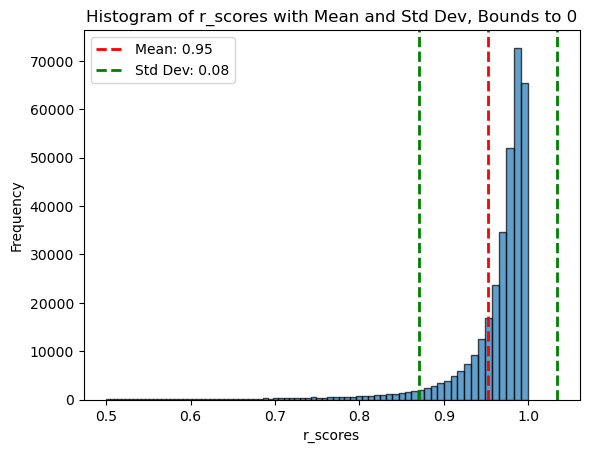

kept 0.9951570989841719% of storms


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# r_scores_full = [outputs[i][2] for i in range(len(outputs)) if outputs[i] is not None]
 
# # Assuming r_scores_growth_rate is defined elsewhere
# r_scores = [score for score in r_scores_full if score is not None]
# r_scores = [score for score in r_scores if score > 0]
# ratio_kept = len(r_scores)/len(outputs)

# # Calculate additional statistics
# mean_score = np.mean(r_scores)
# std_dev = np.std(r_scores)

# # Create histogram with manually adjusted bins
# log_bins = np.logspace(np.log10(0.5), 0, 80)
# bins = np.concatenate([log_bins])

# plt.hist(r_scores, bins=bins, edgecolor='black', alpha=0.7)

# # Add mean and standard deviation to the plot
# plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_score:.2f}')
# plt.axvline(mean_score + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {std_dev:.2f}')
# plt.axvline(mean_score - std_dev, color='green', linestyle='dashed', linewidth=2)

# # Add labels and title
# plt.xlabel('r_scores')
# plt.ylabel('Frequency')
# plt.title('Histogram of r_scores with Mean and Std Dev, Bounds to 0')

# # Show legend
# plt.legend()

# # Display the plot
# plt.show()

# print(f"kept {ratio_kept}% of storms")

In [ ]:
# # could be saved
# mean_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['mean'])[0][0,0,:,:]
# max_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['max'])[0][0,0,:,:]

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

Text(0.5, 1.0, 'Mean growth rate')

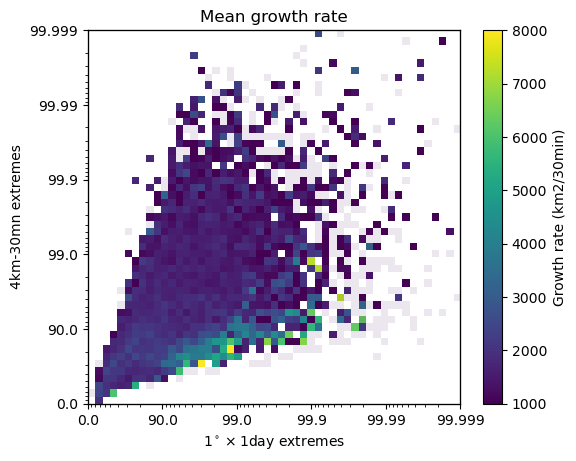

In [ ]:
# data = mean_growth_rate
# jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (km2/30min)', vbds = (1000, 8000))
# plt.title("Mean growth rate")

Text(0.5, 1.0, 'Max growth rate')

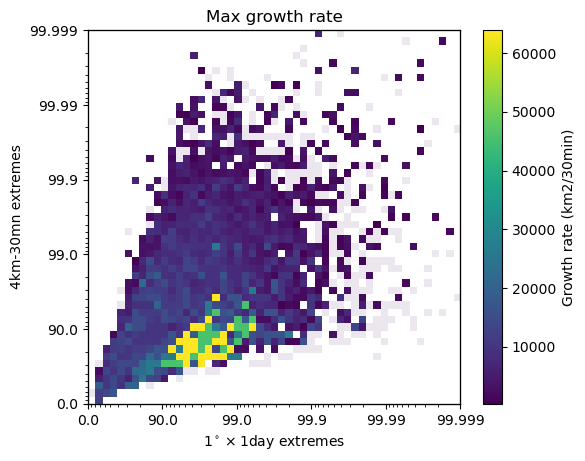

In [ ]:
# data = max_growth_rate
# jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (km2/30min)')
# plt.title("Max growth rate")

# Normalize Growth_rate

In [ ]:
# for storm, growth_rate, output in zip(jd.storms, storms_growth_rates, outputs):
#         if output is not None :
#                 r_score = output[0]
#                 if r_score >0.85:
#                         setattr(storm, 'growth_rate_0.85', growth_rate)
#                         normalized_growth_rate = growth_rate / storm.surfmaxkm2_172Wm2
#                         setattr(storm, 'normalized_growth_rate_0.85', normalized_growth_rate)
#                 if r_score >0.94:
#                         setattr(storm, 'growth_rate_0.94', growth_rate)
#                         normalized_growth_rate = growth_rate / storm.surfmaxkm2_172Wm2
#                         setattr(storm, 'normalized_growth_rate_0.94', normalized_growth_rate)
#                 else :
#                         setattr(storm, 'growth_rate_0.85', np.nan)
#                         setattr(storm, 'normalized_growth_rate_0.85', np.nan)
#                         setattr(storm, 'growth_rate_0.94', np.nan)
#                         setattr(storm, 'normalized_growth_rate_0.94', np.nan)
#         else :
#                 setattr(storm, 'growth_rate_0.85', np.nan)
#                 setattr(storm, 'normalized_growth_rate_0.85', np.nan)
#                 setattr(storm, 'growth_rate_0.94', np.nan)
#                 setattr(storm, 'normalized_growth_rate_0.94', np.nan)

In [ ]:
# # could be saved
# mean_growth_rate_85 = jd.storm_attributes_on_jdist(['growth_rate_0.85'], ['mean'])
# mean_growth_rate_94 = jd.storm_attributes_on_jdist(['growth_rate_0.94'], ['mean'])

# # max_normalized_growth_rate = jd.storm_attributes_on_jdist(['normalized_growth_rate'], ['max'])[0][0,0,:,:]

0123456789101112131415

/home/mcarenso/code/tempest/tempest/joint_distrib.py:807: RuntimeWarning: Mean of empty slice
  out_ij[i_attr,i_func,i_bin,j_bin] = getattr(np,'nan%s'%f)(attr_list)


161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

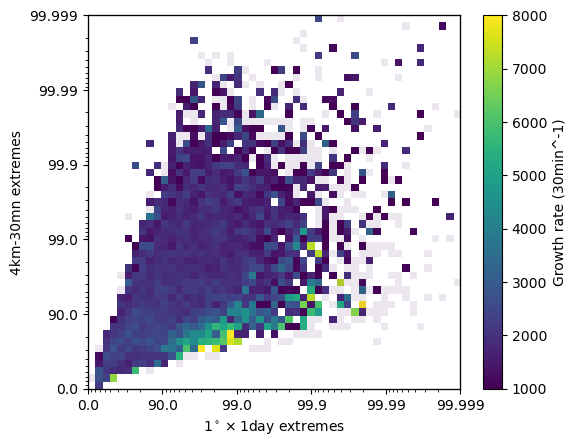

In [ ]:
# data = mean_growth_rate_94
# jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (30min^-1)', vbds = (1000, 8000))#(0.15, 0.25)) #, vbds = (1000, 8000))